Using device: cuda
Dataset initialized. Root: '/kaggle/input/vangogh-run1/run_1', Class mapping: {'authentic': 0, 'imitation': 1}
Generated 20818 patches from 1507 paintings.
Train samples: 14602 (70.1%)
Val samples: 3076 (14.8%) - NOT USED
Test samples: 3140 (15.1%)
Classes: ['authentic', 'imitation']

TRAINING MODELS AND MONITORING TEST LOSS STABILITY


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]


=== TRAINING UNSTABLE MODEL ===

Epoch 1/30 - Unstable Model


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 1 | Batch 50/913 | Loss 1.351683
  Epoch 1 | Batch 100/913 | Loss 1.340441
  Epoch 1 | Batch 150/913 | Loss 1.918794
  Epoch 1 | Batch 200/913 | Loss 1.737213
  Epoch 1 | Batch 250/913 | Loss 0.005915
  Epoch 1 | Batch 300/913 | Loss 0.595943
  Epoch 1 | Batch 350/913 | Loss 0.412198
  Epoch 1 | Batch 400/913 | Loss 0.314258
  Epoch 1 | Batch 450/913 | Loss 0.619640
  Epoch 1 | Batch 500/913 | Loss 0.283536
  Epoch 1 | Batch 550/913 | Loss 0.058258
  Epoch 1 | Batch 600/913 | Loss 0.703918
  Epoch 1 | Batch 650/913 | Loss 0.845700
  Epoch 1 | Batch 700/913 | Loss 1.254469
  Epoch 1 | Batch 750/913 | Loss 0.245063
  Epoch 1 | Batch 800/913 | Loss 0.789719
  Epoch 1 | Batch 850/913 | Loss 0.038439
  Epoch 1 | Batch 900/913 | Loss 1.475837
  Train Loss: 0.899031 | Test Loss: 172.671356 | Test Acc: 0.902229

Epoch 2/30 - Unstable Model
  Epoch 2 | Batch 50/913 | Loss 0.000472
  Epoch 2 | Batch 100/913 | Loss 0.005371
  Epoch 2 | Batch 150/913 | Loss 0.268393
  Epoch 2 | Batch 200/9

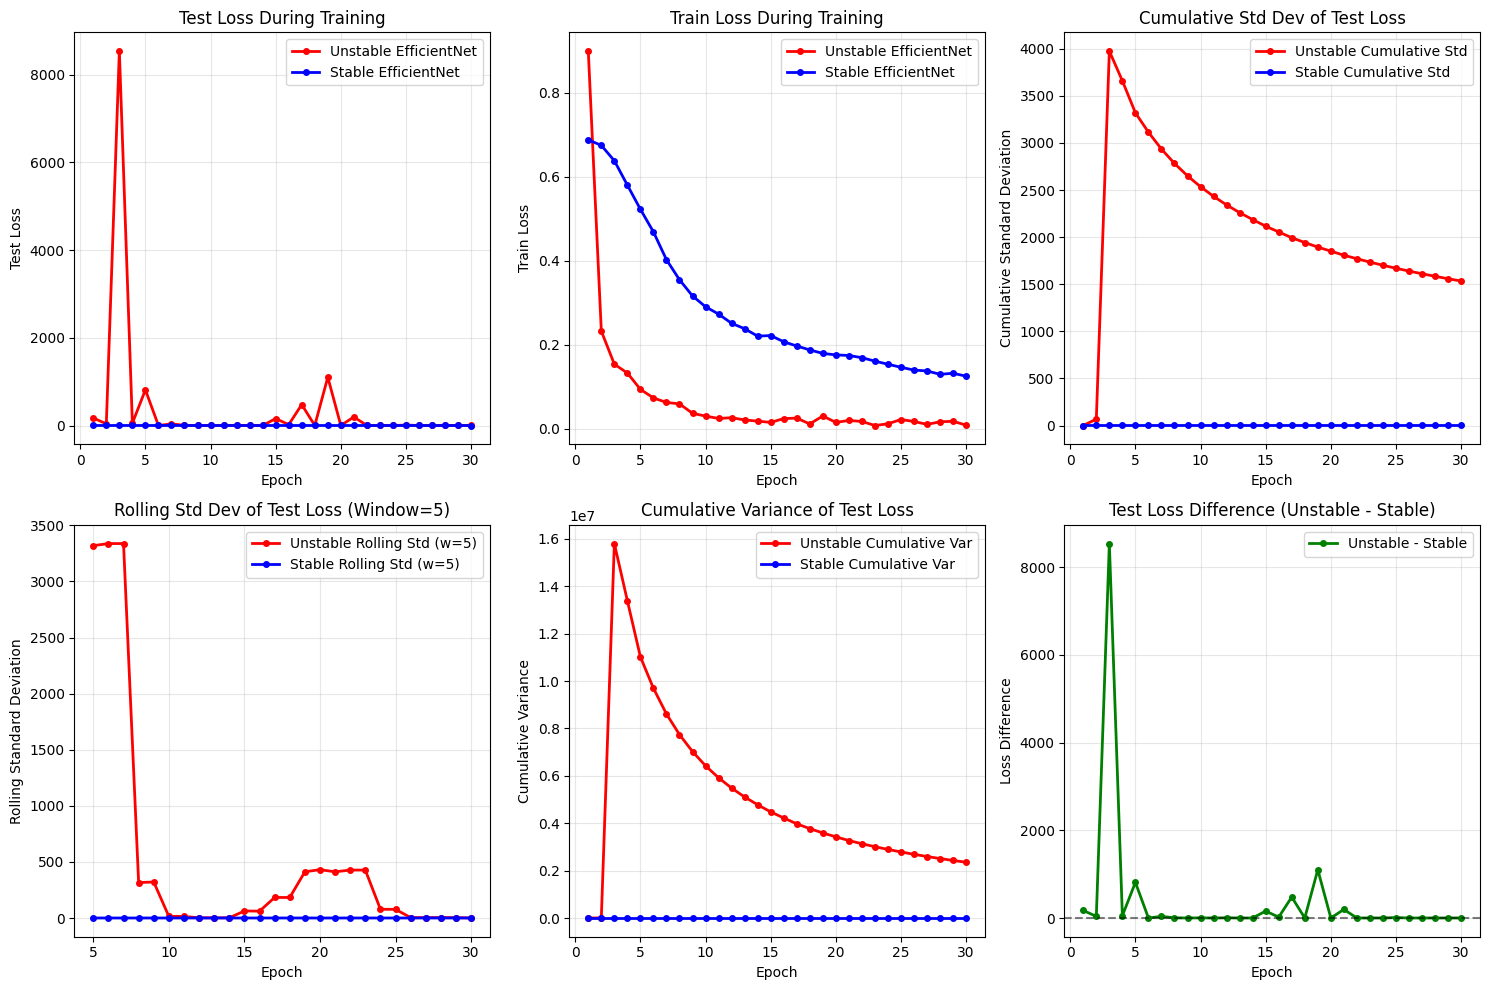


Bootstrap Stability Test (1000 samples)
Unstable model std: 1533.710640
Stable model std: 0.132302
Observed difference (unstable - stable): 1533.578339

Bootstrap Results:
Mean difference: 1229.001271
90% CI: [148.700907, 2537.718254]
95% CI: [95.104747, 2549.961537]
P-value (stable more stable): 0.0000

Interpretation:
Stable model has lower test loss variance
Difference is statistically significant (p < 0.05)
95% CI excludes zero → Stable significantly more stable

ADDITIONAL STABILITY METRICS
Unstable Model:
  Mean test loss: 387.748881
  Std dev: 1533.710640
  Coefficient of variation: 3.955422
  Range: 8536.577913
  IQR: 48.455732

Stable Model:
  Mean test loss: 0.331783
  Std dev: 0.132302
  Coefficient of variation: 0.398760
  Range: 0.455640
  IQR: 0.081461

Stability Improvement:
  Std dev reduction: 99.99%
  CV reduction: 89.92%
  Range reduction: 99.99%

Results saved to: /kaggle/working/Training Data/training_stability_analysis_2025-09-17_08-42-16.json

TRAINING STABILITY

In [1]:
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
import timm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import GroupShuffleSplit
import torch.nn.utils as U
from collections import defaultdict, Counter
import json
from datetime import datetime
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch.nn.functional as F

class MultiPatchDataset(Dataset):
    def __init__(self, root_dir, target_size=256, imitation_weight=1.0):
        self.root_dir = root_dir
        self.target_size = target_size
        self.imitation_weight = imitation_weight
        self.defined_classes = ['authentic', 'imitation']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.defined_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print(f"Dataset initialized. Root: '{self.root_dir}', Class mapping: {self.class_to_idx}")

        self.all_patches = []
        self._prepare_data()

        self.transform = transforms.Compose([
            transforms.Resize((self.target_size, self.target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _prepare_data(self):
        painting_id_counter = 0
        for class_name in self.defined_classes:
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory not found: {class_path}")
                continue

            label = self.class_to_idx[class_name]
            image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if not image_files:
                print(f"Warning: No image files found in {class_path}")
                continue

            for img_filename in image_files:
                img_path = os.path.join(class_path, img_filename)
                current_painting_id = painting_id_counter

                try:
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    max_dim = max(w, h)

                    if max_dim == 0:
                        print(f"Warning: Image {img_path} has zero dimension, skipping.")
                        continue

                    if max_dim > 1024:
                        grid_size = 4
                    elif max_dim >= 512:
                        grid_size = 2
                    else:
                        grid_size = 1

                    patch_width = w // grid_size
                    patch_height = h // grid_size

                    if patch_width == 0 or patch_height == 0:
                         print(f"Warning: Calculated patch size is zero for {img_path}, skipping.")
                         continue

                    for i in range(grid_size):
                        for j in range(grid_size):
                            left = j * patch_width
                            upper = i * patch_height
                            right = (j + 1) * patch_width if (j + 1) < grid_size else w
                            bottom = (i + 1) * patch_height if (i + 1) < grid_size else h
                            
                            patch_img = img.crop((left, upper, right, bottom))
                            if patch_img.size[0] > 0 and patch_img.size[1] > 0:
                                self.all_patches.append((patch_img, label, current_painting_id))
                    
                    painting_id_counter += 1

                except UnidentifiedImageError:
                    print(f"Warning: Cannot identify image file {img_path}, skipping.")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
        
        if not self.all_patches:
            print(f"Warning: No patches were generated.")
        else:
            print(f"Generated {len(self.all_patches)} patches from {painting_id_counter} paintings.")

    def __len__(self):
        return len(self.all_patches)

    def __getitem__(self, idx):
        patch_img, label, painting_id = self.all_patches[idx]
        
        try:
            transformed_patch = self.transform(patch_img)
        except Exception as e:
            print(f"Error transforming patch (original index {idx}, painting_id {painting_id}): {e}")
            transformed_patch = torch.zeros((3, self.target_size, self.target_size), dtype=torch.float32)
            
        return transformed_patch, label, painting_id

def create_model_unstable():
    model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=2)
    return model

def create_model_stable():
    model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=2)
    
    print("Applying targeted weight initialization...")
    for name, param in model.named_parameters():
        if 'classifier' in name and 'weight' in name:
            nn.init.normal_(param, 0, 0.001)
        elif 'classifier' in name and 'bias' in name:
            nn.init.constant_(param, 0)
        elif 'se.' in name and 'weight' in name:
            param.data *= 0.1
        elif 'blocks.6' in name and 'conv_pw' in name and 'weight' in name:
            param.data *= 0.5
        elif 'conv_head' in name and 'weight' in name:
            param.data *= 0.7
    
    return model

class WarmupLRScheduler:
    def __init__(self, optimizer, base_lr=1e-6, warmup_epochs=5, warmup_start_factor=0.1):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.warmup_epochs = warmup_epochs
        self.warmup_start_factor = warmup_start_factor
        
    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            warmup_progress = epoch / self.warmup_epochs
            factor = self.warmup_start_factor + (1.0 - self.warmup_start_factor) * warmup_progress
            return self.base_lr * factor
        else:
            return self.base_lr
    
    def step(self, epoch):
        lr = self.get_lr(epoch)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

def train_one_epoch(model, loader, optimizer, loss_fn, device, epoch=None):
    model.train()
    total_loss = 0

    for batch_idx, (x, y, _) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        
        U.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * x.size(0)

        if epoch is not None and batch_idx % 50 == 0:
            print(f"  Epoch {epoch+1} | Batch {batch_idx}/{len(loader)} | Loss {loss.item():.6f}")

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

def eval_dataset_with_loss(model, loader, loss_fn, device):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    avg_loss = total_loss / total_samples
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    y_true = list(group_labels.values())
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

def bootstrap_stability_test(unstable_losses, stable_losses, n_bootstrap=1000):
    print(f"\nBootstrap Stability Test ({n_bootstrap} samples)")
    print("="*50)
    
    unstable_std = np.std(unstable_losses)
    stable_std = np.std(stable_losses)
    observed_diff = unstable_std - stable_std
    
    print(f"Unstable model std: {unstable_std:.6f}")
    print(f"Stable model std: {stable_std:.6f}")
    print(f"Observed difference (unstable - stable): {observed_diff:.6f}")
    
    np.random.seed(42)
    bootstrap_diff = []
    
    for _ in range(n_bootstrap):
        boot_unstable = np.random.choice(unstable_losses, size=len(unstable_losses), replace=True)
        boot_stable = np.random.choice(stable_losses, size=len(stable_losses), replace=True)
        
        diff = np.std(boot_unstable) - np.std(boot_stable)
        bootstrap_diff.append(diff)
    
    bootstrap_diff = np.array(bootstrap_diff)
    
    p_value = np.mean(bootstrap_diff <= 0)
    
    ci_90_lower = np.percentile(bootstrap_diff, 5.0)
    ci_90_upper = np.percentile(bootstrap_diff, 95.0)
    ci_95_lower = np.percentile(bootstrap_diff, 2.5)
    ci_95_upper = np.percentile(bootstrap_diff, 97.5)
    
    print(f"\nBootstrap Results:")
    print(f"Mean difference: {np.mean(bootstrap_diff):.6f}")
    print(f"90% CI: [{ci_90_lower:.6f}, {ci_90_upper:.6f}]")
    print(f"95% CI: [{ci_95_lower:.6f}, {ci_95_upper:.6f}]")
    print(f"P-value (stable more stable): {p_value:.4f}")
    
    print(f"\nInterpretation:")
    if observed_diff > 0:
        print(f"Stable model has lower test loss variance")
        if p_value < 0.05:
            print(f"Difference is statistically significant (p < 0.05)")
        elif p_value < 0.10:
            print(f"Difference is marginally significant (p < 0.10)")
        else:
            print(f"Difference is not statistically significant")
    else:
        print(f"Unstable model actually has lower variance")
    
    if ci_95_lower > 0:
        print(f"95% CI excludes zero → Stable significantly more stable")
    elif ci_90_lower > 0:
        print(f"90% CI excludes zero → Stable marginally more stable")
    else:
        print(f"Confidence intervals include zero → No significant difference")
    
    return {
        'unstable_std': unstable_std,
        'stable_std': stable_std,
        'observed_diff': observed_diff,
        'mean_diff': np.mean(bootstrap_diff),
        'p_value': p_value,
        'ci_90': [ci_90_lower, ci_90_upper],
        'ci_95': [ci_95_lower, ci_95_upper],
        'bootstrap_diff': bootstrap_diff
    }

def train_and_test_stability(model, train_loader, test_loader, optimizer, scheduler, loss_fn, device, epochs, model_name):
    """
    Train model and evaluate test loss stability during training
    """
    print(f"\n=== TRAINING {model_name.upper()} MODEL ===")
    
    test_losses_per_epoch = []
    train_losses_per_epoch = []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs} - {model_name} Model")
        
        # Train one epoch
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device, epoch)
        train_losses_per_epoch.append(train_loss)
        
        # Evaluate on test set
        test_acc, test_loss = eval_dataset_with_loss(model, test_loader, loss_fn, device)
        test_losses_per_epoch.append(test_loss)
        
        # Update scheduler
        if hasattr(scheduler, 'step'):
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
            elif hasattr(scheduler, 'get_lr'):  # WarmupLRScheduler
                if epoch < 5:
                    current_lr = scheduler.step(epoch)
                    print(f"  Warmup LR: {current_lr:.2e}")
            else:
                scheduler.step()
        
        print(f"  Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Test Acc: {test_acc:.6f}")
    
    return train_losses_per_epoch, test_losses_per_epoch

def main():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    # Load dataset
    root_dir = '/kaggle/input/vangogh-run1/run_1'  # adjust path as needed
    ds = MultiPatchDataset(root_dir, target_size=256, imitation_weight=1.0)
    groups = [pid for _, _, pid in ds.all_patches]

    # Modified splitting with GroupShuffleSplit for 70/15/15 split
    # First split: 70% train, 30% temp (which will be split into 15% val, 15% test)
    gss1 = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idx, temp_idx = next(gss1.split(ds.all_patches, groups=groups))

    # Second split: Split the 30% temp into 15% val and 15% test (50/50 of the temp)
    temp_groups = [groups[i] for i in temp_idx]
    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
    val_idx_temp, test_idx_temp = next(gss2.split([ds.all_patches[i] for i in temp_idx], groups=temp_groups))

    # Map back to original indices
    val_idx = [temp_idx[i] for i in val_idx_temp]
    test_idx = [temp_idx[i] for i in test_idx_temp]

    print(f"Train samples: {len(train_idx)} ({len(train_idx)/len(ds.all_patches)*100:.1f}%)")
    print(f"Val samples: {len(val_idx)} ({len(val_idx)/len(ds.all_patches)*100:.1f}%) - NOT USED")
    print(f"Test samples: {len(test_idx)} ({len(test_idx)/len(ds.all_patches)*100:.1f}%)")
    print(f"Classes: {list(ds.class_to_idx.keys())}")

    # Create datasets (validation set created but not used)
    train_dataset = Subset(ds, train_idx)
    val_dataset = Subset(ds, val_idx)  # Created but not used
    test_dataset = Subset(ds, test_idx)

    # Create weighted sampler for training
    train_labels = np.array([ds.all_patches[i][1] for i in train_idx])
    weights = [ds.imitation_weight if label == ds.class_to_idx.get('imitation', 1) else 1 for label in train_labels]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    # Calculate class weights
    train_labels_counts = [ds.all_patches[i][1] for i in train_idx]
    class_counts = Counter(train_labels_counts)
    num_classes = len(ds.class_to_idx)
    weights_list = [len(train_labels_counts) / (num_classes * count) for count in class_counts.values()]
    class_weights = torch.tensor(weights_list, dtype=torch.float).to(device)

    EPOCHS = 30
    PATIENCE_REDUCE_LR = 5

    # =================
    # TRAINING MODELS AND COLLECTING TEST LOSSES
    # =================
    print("\n" + "="*80)
    print("TRAINING MODELS AND MONITORING TEST LOSS STABILITY")
    print("="*80)

    # Train unstable model
    unstable_model = create_model_unstable().to(device)
    unstable_optimizer = torch.optim.AdamW(unstable_model.parameters(), lr=1e-5, weight_decay=1e-2)
    unstable_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        unstable_optimizer, mode='min', factor=0.5, patience=PATIENCE_REDUCE_LR, verbose=True
    )
    unstable_loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    unstable_train_losses, unstable_test_losses = train_and_test_stability(
        unstable_model, train_loader, test_loader, unstable_optimizer, 
        unstable_scheduler, unstable_loss_fn, device, EPOCHS, "Unstable"
    )

    # Train stable model
    stable_model = create_model_stable().to(device)
    stable_optimizer = torch.optim.AdamW(stable_model.parameters(), lr=1e-7, weight_decay=1e-2)
    stable_loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
    
    # Use warmup scheduler for stable model
    warmup_scheduler = WarmupLRScheduler(stable_optimizer, base_lr=1e-6, warmup_epochs=5, warmup_start_factor=0.1)
    
    stable_train_losses, stable_test_losses = train_and_test_stability(
        stable_model, train_loader, test_loader, stable_optimizer, 
        warmup_scheduler, stable_loss_fn, device, EPOCHS, "Stable"
    )

    # =================
    # STABILITY ANALYSIS ON TEST LOSSES DURING TRAINING
    # =================
    print("\n" + "="*80)
    print("STABILITY ANALYSIS ON TEST LOSSES DURING TRAINING")
    print("="*80)

    # Plot training curves
    epochs_range = list(range(1, EPOCHS + 1))
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Test Loss During Training
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, unstable_test_losses, 'r-o', label='Unstable EfficientNet', linewidth=2, markersize=4)
    plt.plot(epochs_range, stable_test_losses, 'b-o', label='Stable EfficientNet', linewidth=2, markersize=4)
    plt.title('Test Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Train Loss During Training
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, unstable_train_losses, 'r-o', label='Unstable EfficientNet', linewidth=2, markersize=4)
    plt.plot(epochs_range, stable_train_losses, 'b-o', label='Stable EfficientNet', linewidth=2, markersize=4)
    plt.title('Train Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative Standard Deviation of Test Loss
    plt.subplot(2, 3, 3)
    unstable_cumulative_std = [np.std(unstable_test_losses[:i+1]) for i in range(len(unstable_test_losses))]
    stable_cumulative_std = [np.std(stable_test_losses[:i+1]) for i in range(len(stable_test_losses))]
    
    plt.plot(epochs_range, unstable_cumulative_std, 'r-o', label='Unstable Cumulative Std', linewidth=2, markersize=4)
    plt.plot(epochs_range, stable_cumulative_std, 'b-o', label='Stable Cumulative Std', linewidth=2, markersize=4)
    plt.title('Cumulative Std Dev of Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Standard Deviation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Rolling Standard Deviation (window=5)
    plt.subplot(2, 3, 4)
    window = 5
    if len(unstable_test_losses) >= window:
        unstable_rolling_std = [np.std(unstable_test_losses[max(0, i-window+1):i+1]) for i in range(window-1, len(unstable_test_losses))]
        stable_rolling_std = [np.std(stable_test_losses[max(0, i-window+1):i+1]) for i in range(window-1, len(stable_test_losses))]
        
        plt.plot(epochs_range[window-1:], unstable_rolling_std, 'r-o', label=f'Unstable Rolling Std (w={window})', linewidth=2, markersize=4)
        plt.plot(epochs_range[window-1:], stable_rolling_std, 'b-o', label=f'Stable Rolling Std (w={window})', linewidth=2, markersize=4)
        plt.title(f'Rolling Std Dev of Test Loss (Window={window})')
        plt.xlabel('Epoch')
        plt.ylabel('Rolling Standard Deviation')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Plot 5: Test Loss Variance Over Time
    plt.subplot(2, 3, 5)
    unstable_cumulative_var = [np.var(unstable_test_losses[:i+1]) for i in range(len(unstable_test_losses))]
    stable_cumulative_var = [np.var(stable_test_losses[:i+1]) for i in range(len(stable_test_losses))]
    
    plt.plot(epochs_range, unstable_cumulative_var, 'r-o', label='Unstable Cumulative Var', linewidth=2, markersize=4)
    plt.plot(epochs_range, stable_cumulative_var, 'b-o', label='Stable Cumulative Var', linewidth=2, markersize=4)
    plt.title('Cumulative Variance of Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Difference in Test Loss
    plt.subplot(2, 3, 6)
    test_loss_diff = [u - s for u, s in zip(unstable_test_losses, stable_test_losses)]
    plt.plot(epochs_range, test_loss_diff, 'g-o', label='Unstable - Stable', linewidth=2, markersize=4)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Test Loss Difference (Unstable - Stable)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Run bootstrap stability test on test losses during training
    bootstrap_results = bootstrap_stability_test(unstable_test_losses, stable_test_losses)

    # =================
    # ADDITIONAL STABILITY METRICS
    # =================
    print("\n" + "="*50)
    print("ADDITIONAL STABILITY METRICS")
    print("="*50)
    
    # Calculate additional metrics
    unstable_mean = np.mean(unstable_test_losses)
    stable_mean = np.mean(stable_test_losses)
    unstable_cv = np.std(unstable_test_losses) / unstable_mean if unstable_mean != 0 else 0
    stable_cv = np.std(stable_test_losses) / stable_mean if stable_mean != 0 else 0
    
    # Calculate range and interquartile range
    unstable_range = np.max(unstable_test_losses) - np.min(unstable_test_losses)
    stable_range = np.max(stable_test_losses) - np.min(stable_test_losses)
    
    unstable_iqr = np.percentile(unstable_test_losses, 75) - np.percentile(unstable_test_losses, 25)
    stable_iqr = np.percentile(stable_test_losses, 75) - np.percentile(stable_test_losses, 25)
    
    print(f"Unstable Model:")
    print(f"  Mean test loss: {unstable_mean:.6f}")
    print(f"  Std dev: {np.std(unstable_test_losses):.6f}")
    print(f"  Coefficient of variation: {unstable_cv:.6f}")
    print(f"  Range: {unstable_range:.6f}")
    print(f"  IQR: {unstable_iqr:.6f}")
    
    print(f"\nStable Model:")
    print(f"  Mean test loss: {stable_mean:.6f}")
    print(f"  Std dev: {np.std(stable_test_losses):.6f}")
    print(f"  Coefficient of variation: {stable_cv:.6f}")
    print(f"  Range: {stable_range:.6f}")
    print(f"  IQR: {stable_iqr:.6f}")
    
    print(f"\nStability Improvement:")
    print(f"  Std dev reduction: {((np.std(unstable_test_losses) - np.std(stable_test_losses))/np.std(unstable_test_losses)*100):.2f}%")
    print(f"  CV reduction: {((unstable_cv - stable_cv)/unstable_cv*100):.2f}%")
    print(f"  Range reduction: {((unstable_range - stable_range)/unstable_range*100):.2f}%")

    # =================
    # SAVE RESULTS
    # =================
    now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    results = {
        "timestamp": now_str,
        "epochs": EPOCHS,
        "split_info": {
            "train_samples": len(train_idx),
            "val_samples": len(val_idx),
            "test_samples": len(test_idx),
            "train_pct": len(train_idx)/len(ds.all_patches)*100,
            "val_pct": len(val_idx)/len(ds.all_patches)*100,
            "test_pct": len(test_idx)/len(ds.all_patches)*100,
            "note": "Validation set created but not used - only test set used for stability analysis"
        },
        "training_results": {
            "unstable_train_losses": unstable_train_losses,
            "unstable_test_losses": unstable_test_losses,
            "stable_train_losses": stable_train_losses,
            "stable_test_losses": stable_test_losses
        },
        "stability_metrics": {
            "unstable_mean": unstable_mean,
            "stable_mean": stable_mean,
            "unstable_std": np.std(unstable_test_losses),
            "stable_std": np.std(stable_test_losses),
            "unstable_cv": unstable_cv,
            "stable_cv": stable_cv,
            "unstable_range": unstable_range,
            "stable_range": stable_range,
            "unstable_iqr": unstable_iqr,
            "stable_iqr": stable_iqr
        },
        "bootstrap_results": {
            "unstable_std": bootstrap_results['unstable_std'],
            "stable_std": bootstrap_results['stable_std'],
            "observed_diff": bootstrap_results['observed_diff'],
            "mean_diff": bootstrap_results['mean_diff'],
            "p_value": bootstrap_results['p_value'],
            "ci_90": bootstrap_results['ci_90'],
            "ci_95": bootstrap_results['ci_95']
        }
    }
    
    os.makedirs('/kaggle/working/Training Data', exist_ok=True)
    json_path = f"/kaggle/working/Training Data/training_stability_analysis_{now_str}.json"
    with open(json_path, 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, dict):
                return {k: convert_numpy(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy(item) for item in obj]
            return obj
        
        json.dump(convert_numpy(results), f, indent=4)
    print(f"\nResults saved to: {json_path}")

    # =================
    # FINAL SUMMARY
    # =================
    print("\n" + "="*80)
    print("TRAINING STABILITY ANALYSIS SUMMARY")
    print("="*80)
    
    stability_significant = bootstrap_results['p_value'] < 0.05
    print(f"Training epochs: {EPOCHS}")
    print(f"Test set size: {len(test_idx)} samples")
    print(f"Stable model more stable: {'YES' if bootstrap_results['observed_diff'] > 0 else 'NO'}")
    print(f"Statistical significance: {'YES' if stability_significant else 'NO'} (p={bootstrap_results['p_value']:.4f})")
    
    if bootstrap_results['observed_diff'] > 0 and stability_significant:
        print(f"\nCONCLUSION: STABLE MODEL IS SIGNIFICANTLY MORE STABLE DURING TRAINING")
    elif bootstrap_results['observed_diff'] > 0:
        print(f"\nCONCLUSION: STABLE MODEL APPEARS MORE STABLE DURING TRAINING (NOT STATISTICALLY SIGNIFICANT)")
    else:
        print(f"\nCONCLUSION: NO EVIDENCE OF IMPROVED STABILITY DURING TRAINING")

    return unstable_test_losses, stable_test_losses, bootstrap_results

if __name__ == "__main__":
    main()